<a href="https://colab.research.google.com/github/claude9493/DSAA5002/blob/main/notebook/BetaRec.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/claude9493/dsaa5002.git
!mv ./dsaa5002/dataset/ ./
!mv ./dsaa5002/utils/ ./

fatal: destination path 'dsaa5002' already exists and is not an empty directory.
mv: cannot stat './dsaa5002/dataset/': No such file or directory
mv: cannot stat './dsaa5002/utils/': No such file or directory


In [2]:
%%time

from utils.utils import create_dataset, Trainer
# from layer.layer import Embedding, FeaturesEmbedding, EmbeddingsInteraction, MultiLayerPerceptron

import math
import torch
import torch.nn as nn
import torch.optim as optim

from torch.utils.data import TensorDataset, DataLoader

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('Training on [{}].'.format(device))

Training on [cuda:0].
CPU times: user 907 ms, sys: 377 ms, total: 1.28 s
Wall time: 1.17 s


In [3]:
%%time
SAMPLE_NUM = 10000
task = 'regression'  # 'classification'
dataset = create_dataset('movielens', sample_num=SAMPLE_NUM, task=task, device=device)
field_dims, (train_X, train_y), (valid_X, valid_y), (test_X, test_y) = dataset.train_valid_test_split()

CPU times: user 1.69 s, sys: 817 ms, total: 2.5 s
Wall time: 2.49 s


In [4]:
# train_iterator = SingledirectionalOneShotIterator(DataLoader(
#     TensorDataset(train_X, train_y),
#     # TrainDataset(train_path_queries, nentity, nrelation, args.negative_sample_size, train_answers),
#     batch_size=BATCH_SIZE,
#     shuffle=True
#     # num_workers=args.cpu_num
#     # collate_fn=TrainDataset.collate_fn
# ))

In [44]:
class SingledirectionalOneShotIterator(object):
    def __init__(self, dataloader):
        self.iterator = self.one_shot_iterator(dataloader)
        self.step = 0
        
    def __next__(self):
        self.step += 1
        data = next(self.iterator)
        return data
    
    @staticmethod
    def one_shot_iterator(dataloader):
        while True:
            for data in dataloader:
                yield data

class Beta_Loss:
    def __init__(self, model, reg_biase=0.005, reg_lambda=0.005):
        self.reg_biase = reg_biase
        self.reg_lambda = reg_lambda
        self.model = model

    def __call__(self, pred, target):
        loss = (1-self.reg_biase) * nn.MSELoss()(pred, torch.squeeze(target))
        loss += self.reg_biase * self.model.loss[0]
        # loss += self.reg_lambda * self.model.loss[1]
        loss = nn.MSELoss(reduction='sum')(pred.view(-1,1), target)
        loss = torch.nan_to_num(loss)
        # print(pred.view(-1,1), target)
        return loss

class Regularizer():
    def __init__(self, base_add, min_val, max_val):
        self.base_add = base_add
        self.min_val = min_val
        self.max_val = max_val

    def __call__(self, entity_embedding):
        return torch.clamp(entity_embedding + self.base_add, self.min_val, self.max_val)


class BetaRecommendation(nn.Module):

    def __init__(self, field_dims, embed_dim=4, **kwargs):
        super(BetaRecommendation, self).__init__()
        n_users, n_movies = field_dims[0], field_dims[1]

        self.gamma = nn.Parameter(
            torch.Tensor([kwargs.get('gamma', 12)]), 
            requires_grad=False
        )

        self.Bu = nn.Parameter(torch.randn(n_users), requires_grad=True)
        self.Bm = nn.Parameter(torch.randn(n_movies), requires_grad=True)

        self.u = nn.Embedding(n_users, embed_dim * 2)
        # self.u = nn.Parameter(torch.zeros(n_users, embed_dim * 2))
        self.m = nn.Embedding(n_movies, embed_dim * 2)
        # self.m = nn.Parameter(torch.zeros(n_movies, embed_dim * 2))
        
        self.u.weight.data.uniform_(0.05, 1e9)
        self.m.weight.data.uniform_(0.05, 1e9)
        
        self.regularizer = Regularizer(1, 0.05, 1e9)
        self.loss = [0,0]

        
    def forward(self, x, global_mean=0):
        users, movies = x[:,0], x[:,1]
        u, m = self.u(users), self.m(movies)
        Bu, Bm = self.Bu[users], self.Bm[movies]
        u[torch.isnan(u)] = 0.05
        m[torch.isnan(m)] = 0.05

        alpha_u, beta_u = torch.chunk(self.regularizer(u), 2, dim=-1)
        alpha_m, beta_m = torch.chunk(self.regularizer(m), 2, dim=-1)

        u_dist = torch.distributions.beta.Beta(alpha_u, beta_u)
        m_dist = torch.distributions.beta.Beta(alpha_m, beta_m)

        distance = self.distance(u_dist, m_dist)
    
        output = Bu + Bm - distance
        
        self.loss[0] = torch.norm(Bu) + torch.norm(Bm)
        # self.loss[1] = torch.norm(u) + torch.norm(m)
        return output
      
    def distance(self, u_dist, m_dist):
      # return torch.norm(torch.distributions.kl.kl_divergence(u_dist, m_dist), p=1, dim=-1)
      
      # print([u_dist, m_dist, 
            #  torch.norm(torch.nan_to_num(torch.log(torch.distributions.kl.kl_divergence(u_dist, m_dist)), 
                                        #  nan=1.0, posinf=1.0), p=1, dim=-1)])

      return torch.nan_to_num(self.gamma - torch.norm(torch.nan_to_num(torch.log(torch.distributions.kl.kl_divergence(u_dist, m_dist)), 
                                                                       nan=1, posinf=1), 
                                                      p=1, dim=-1))
      # return torch.norm(torch.pi/2.0 * torch.atan(torch.distributions.kl.kl_divergence(u_dist, m_dist)), p=1, dim=-1)

    @staticmethod
    def train_step(model, optimizer, train_iterator, args, step):
      model.train()
      optimizer.zero_grad()
      x, y = next(train_iterator)
      users, movies = x[:,0], x[:,1]

      batch_queries_dict = collections.defaultdict(list)
      batch_idxs_dict = collections.defaultdict(list)


Train loss: 0.0 Validation loss: 0.0:  20%|██        | 100/500 [00:09<00:38, 10.51it/s]


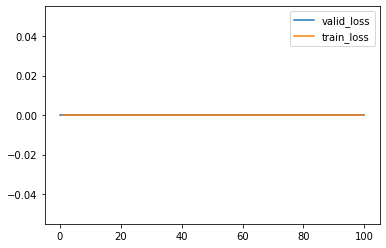

train_loss: 0.00000 | train_metric: -0.00000
valid_loss: 0.00000 | valid_metric: -0.00000
test_loss:  0.00000 | test_metric:  -0.00000
CPU times: user 9.55 s, sys: 192 ms, total: 9.74 s
Wall time: 9.83 s


In [45]:
%%time

EMBEDDING_DIM = 16
LEARNING_RATE = 1e-4
REGULARIZATION = 1e-6
BATCH_SIZE = 1024
EPOCH = 500
TRIAL = 100

br = BetaRecommendation(field_dims, EMBEDDING_DIM).to(device)

optimizer = optim.Adam(br.parameters(), lr=LEARNING_RATE, weight_decay=REGULARIZATION)
# criterion = nn.BCELoss()
# criterion = nn.CrossEntropyLoss()
criterion = Beta_Loss(model=br)

trainer = Trainer(br, optimizer, criterion, BATCH_SIZE, task=task)
trainer.train(train_X, train_y, epoch=EPOCH, trials=TRIAL, valid_X=valid_X, valid_y=valid_y)
test_loss, test_metric = trainer.test(test_X, test_y)
print('test_loss:  {:.5f} | test_metric:  {:.5f}'.format(test_loss, test_metric))